# Homework 8

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-20

* Alex Popovici
* alex.popovici@uchicago.edu

In [2]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

-----------------------------------------------------------
# Problem 1: Options Pricing and Volatility Smiles in the Merton Structural Credit Model
## Follow Lecture 7, "Structural Credit Default Models"

We assume the following input values in the Merton Structural Credit Model
- Initial Assets of 1 (e.g. think about 1 $BN in assets at time 0)
- Face value of Liabilities K: 0.9 (e.g. initial leverage of 90%)
- Bond maturity T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%
- Log-normal distribution of assets at time T, using Lecture 7 Formula (27):

$A_{T}=A_{0}\cdot\exp\left[\left(r-\frac{1}{2}\sigma_{A}^{2}\right)\cdot T+\sigma_{A}\cdot W_{T}\right]$


## a. Distributions of Assets and Equity fair values at time t = 1 year


Use the following discretization grid for Asset at time t: [a from 0.02 to 2 in steps of 0.02].

Compute the density (PDF) and cumulative density (CDF) of Assets at time t.

For each value of the assets, compute the fair value of Equity at time t.

Plot the results: Assets PDF, Assest CDF and Equity fair value at time t.

You can use lognorm from scipy.stats for the log-normal distribution PDF/CFD.

<Axes: title={'center': 'Asset PDFs, CFDs and Equity fair values (t = 1 year)'}, xlabel='Assets_t'>

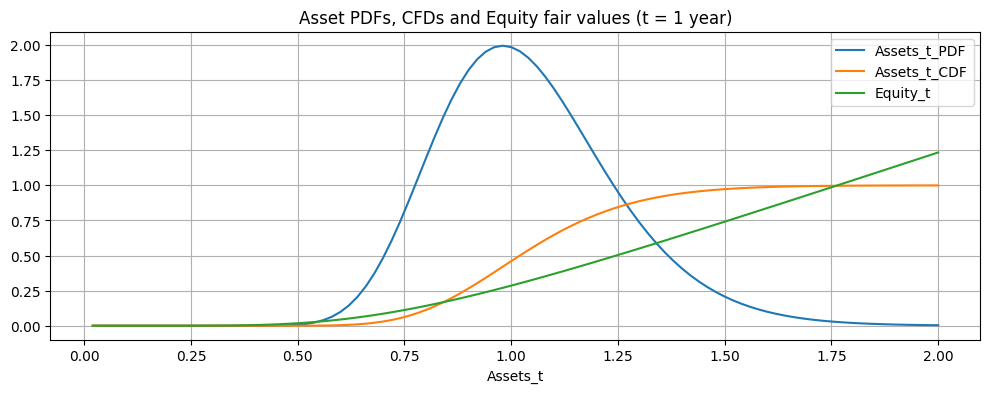

In [3]:
from scipy.stats import lognorm

# Merton Structural Credit Model parameters
A_0 = 1         # Initial Assets
K = 0.9         # Face Value of Liabilities
T = 5           # Bond maturity T / Merton Model time horizon T
t = 1           # Analysis time horizon t
sigma_A = 0.2   # Assets volatility
r = 0.04        # Risk-free interest rate

# Generate assets grid
assets_grid = np.linspace(0.02, 2, 100)

# Parameters for the underlying normal distribution
mu = np.log(A_0) + (r - 0.5 * sigma_A * sigma_A) * t    # Mean of the normal distribution
sigma_A = sigma_A * np.sqrt(t)                            # Standard deviation of the normal distribution

# Create a log-normal distribution instance
assets_dist = lognorm(s=sigma_A, scale=np.exp(mu))

# Calculate the assets PDF
assets_pdf = assets_dist.pdf(assets_grid)
assets_cdf = assets_dist.cdf(assets_grid)

# Create assets_df
assets_df = pd.DataFrame({
                            "Assets_t": assets_grid, 
                            "Assets_t_PDF": assets_pdf, 
                            "Assets_t_CDF": assets_cdf})

# Add the Equity fair value at t = 1 year
assets_df["Equity_t"] = [fairValueEquity(a, r, sigma_A, T-t, K) for a in assets_grid]

# display(assets_df.head())

# Plot the Asset PDFs, CFDs and Equity fair values at t = 1 year
assets_df.plot(x="Assets_t", title='Asset PDFs, CFDs and Equity fair values (t = 1 year)', grid=True, figsize=(12,4)) # , style='-*'

## b. Compute the value of an Europen ATM (At-The-Money) Call option with maturity t = 1 year.

For ATM options, the strike k equals the equity value at time 0, i.e. $k = E_0$.

The Call Option value can be obtained by numerical integration of the call payoff function against the log-normal density of $A_t$, as derived in Lecture 7 formula (47).

You can use quad from scipy.integrate for numerical integration.

$EquityCall\left(E_{0},k,t\right)=e^{-r\cdot t}\cdot\mathbb{E}\left[\left(E_{t}-k\right)^{+}|\mathcal{F}_{0}\right]$

$=e^{-r\cdot t}\cdot\mathbb{E}\left[\left(Call\left(A_{t},K,T-t,\sigma_{A},r,\right)-k\right)^{+}|\mathcal{F}_{0}\right]$

$=\int_{-\infty}^{\infty}e^{-r\cdot t}\cdot\left(Call\left(x,K,T-t,\sigma_{A},r,\right)-k\right)^{+} \cdot \phi_{A_{t}} \, dx$

In [4]:
# Compute ATM strike k = E_0
E_0 = fairValueEquity(A_0, r, sigma_A, T, K)
k_atm = E_0

print("E_0 (ATM strike k) =", round(k_atm,4))

E_0 (ATM strike k) = 0.3188


In [5]:
from scipy.integrate import quad

# merton_structural_credit_model_call
def merton_structural_credit_model_equity_call(k):

    # Numerical integration
    def integrand(A_t):
        E_t = fairValueEquity(A_t, r, sigma_A, T-t, K)
        call_option_payout = np.maximum(E_t - k, 0)
        return np.exp(-r * t) * call_option_payout * assets_dist.pdf(A_t)

    # Integrate over A_t from from 0 to infinity
    europen_call_price, _ = quad(integrand, 0, np.inf)    
    return(europen_call_price)

# europen_call_price_atm
europen_call_price_atm = merton_structural_credit_model_equity_call(k_atm)

# print Results
print(f"Numerically Integrated Europen Call Price in Merton model: {europen_call_price_atm:.4f}")

Numerically Integrated Europen Call Price in Merton model: 0.0714


## c. Compute the Implied Volatility of the ATM European Call Option

Implement a function to compute the Implied Volatility in the Black-Scholes model (using European Call option price as input)

Compute the Implied Volatility of the ATM European Call Option.

Use a numerical root finder, e.g. root_scalar from scipy.optimize.

In [6]:
from scipy.optimize import root_scalar

# Analytical Black-Scholes price
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# black_scholes_implied_vol
def black_scholes_implied_vol(S_0, K, T, r, call_price):

    # call_price_from_implied_vol
    call_price_from_implied_vol = lambda sigma: black_scholes_call(S_0, K, T, r, sigma) - call_price

    # use 1-dimensional root finder
    root_finder_implied_vol_sol = root_scalar(call_price_from_implied_vol, bracket=[0.001, 2], method='brentq', xtol=1e-6)    

    # root_scalar() convergence details
    # print(root_finder_implied_vol_sol)

    return root_finder_implied_vol_sol.root

option_implied_vol = black_scholes_implied_vol(E_0, k_atm, t, r, europen_call_price_atm)
print('option_implied_vol:', round(option_implied_vol, 4))

option_implied_vol: 0.5271


## d. Plot the option Implied Volatility Smile in the Merton model

Use a grid of strikes [k from 80% to 120% in steps of 5%], relative to the spot equity price E_0.

Compute the European Call options prices and the corresponding option Implied Volatilities on the above grid.
Plot the Implied Volatility smile (Implied Volatities by strikes).

In [7]:
# Generate assets grid
relative_strikes_grid = np.linspace(50, 150, 21)
strikes_grid = relative_strikes_grid * E_0 / 100
european_call_prices = []
option_implied_vols = []

for i in range(strikes_grid.size):

    # strike k
    k = strikes_grid[i]

    # european_call_price
    european_call_price = merton_structural_credit_model_equity_call(k)
    european_call_prices.append(european_call_price)
    # print('european_call_price =', european_call_price)

    # option_implied_vol
    option_implied_vol = black_scholes_implied_vol(E_0, k, t, r, european_call_price)
    option_implied_vols.append(option_implied_vol)
    # print('option_implied_vol =', option_implied_vol)



<Axes: title={'center': 'Implied Volatility Smile in the Merton Structural Credit model'}, xlabel='Option_Strikes'>

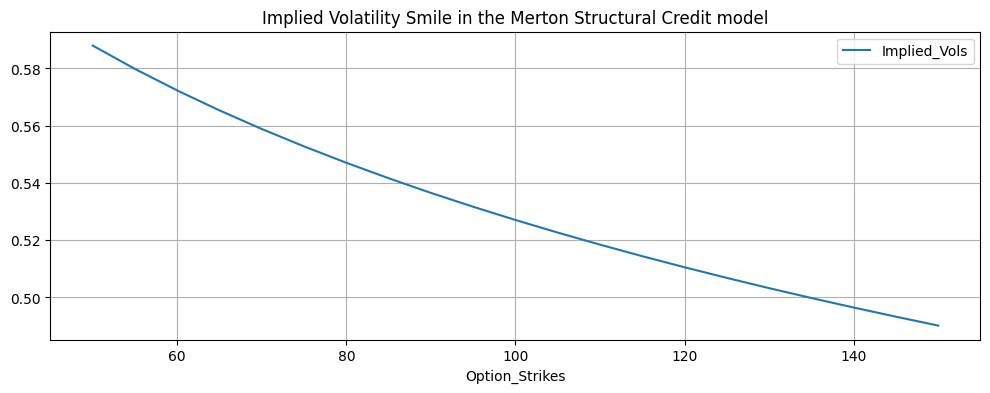

In [8]:
# Create options_df
options_df = pd.DataFrame({
                            "Option_Strikes": relative_strikes_grid, 
                            "Call_Prices": european_call_prices, 
                            "Implied_Vols": option_implied_vols})

# Plot option implied volatilities
options_df.plot(x="Option_Strikes", y=['Implied_Vols'], title='Implied Volatility Smile in the Merton Structural Credit model', grid=True, figsize=(12,4)) # , style='-*'

-----------------------------------------------------------
# Problem 2: Pricing Convertible Bonds in the Merton Structural Credit Model
## Follow Lecture 7, "Structural Credit Default Models"

A convertible bond is a type of corporate bond that can be converted into a predetermined number of the issuing company’s common stock ("conversion ratio") at the bondholder’s discretion, typically at specific dates. The conversion to equity is optional, so bondholders can choose to hold the bond to maturity for interest and principal repayment instead.

Benefits for convertible bond investors:
- Income from interest payments.
- Potential capital gains if the stock price increases and conversion is profitable.
- Lower risk than owning stock directly, as bondholders are prioritized over shareholders in case of bankruptcy.

Benefits for convertible bond issuers:
- Lower interest rates than regular bonds due to the conversion feature’s appeal.
- Potential to reduce debt if bonds are converted to equity.


The Merton structural credit model (1974) provides a framework for pricing convertible bonds by treating them as hybrid instruments with both debt and equity characteristics.

### Recap of model assumptions

- Constant interest rates r

- Constant asset volatility $\sigma_{A}$

- Asset value process $A_{t}$ follows a geometric Brownian motion with drift r under risk neutral measure $\mathbb{P}$

- Liabilities consist of one zero-coupon convertible bond with face value K and maturity T

- Conversion details: at time T, the convertible bond can be converted to equity at a conversion ratio of $C \in (0,1)$ relative to the assets $A_{T}$ (i.e. for a convertible bond payout of $C \cdot A_{T}$ at time T, in case of conversion)

- Credit default triggered if value of assets $A_{T}$ is below liabilities K at maturity T.


## a. Compute the fair value of the Convertible Bond

Derive the formula for the Convertible Bond payout at time T and compute the fair value $CB_0$ of the convertible bond at time 0.

You can use the formulas for the fair value of the "vanilla" corporate bond $B_0$ (without callability) at time 0, derived in Lecture 7.

For which values of $A_T$ is it economical for the convertible bond holder to exercise the call option?

- Derive the formula for the Convertible Bond payout at time T:

\begin{align}
ConvertibleBondPayout(A_T)=\max\left(\min\left(K, A_{T}\right), C \cdot A_{T}\right)
\end{align}

\begin{align}
 = \min\left(K, A_{T}\right) + \left(C \cdot A_{T} - \min\left(K, A_{T}\right)\right)^+
\end{align}

\begin{align}
 = \min\left(K, A_{T}\right) + \left(C \cdot A_{T} - K\right)^+
\end{align}

\begin{align}
 = VanillaBondPayout(A_T) + ConversionCallOption\left(C \cdot A_{T}, K\right)
\end{align}

- Compute the fair value $CB_0$ of the convertible bond at time 0:

\begin{align}
CB_{0}=e^{-r\cdot T}\cdot\mathbb{E}\left[\min\left(K, A_{T}\right) + \left(C \cdot A_{T} - K\right)^+ \right]
\end{align}

\begin{align}
=B_0 + CallOption\left(C \cdot A_{0},K,T,\sigma_{A},r\right)
\end{align}

For which values of $A_T$ does it make sense for the convertible bond holder to exercise the call option? 

The bond conversion only makes sense if the conversion call option with payout $\left(C \cdot A_{T} - K\right)^+$ finishes in the money. This only happens if $A_{T} > \frac{K}{C}$!

## b. Compute the fair value of (Convertible) Equity

Derive the formula for the (Convertible) Equity Investor payout at time T: take into acount that the equity investor gets dilluted if the convertible bond is exercised.

Compute the fair value $CE_0$ of equity at time 0. 

You can use the formulas for the fair value of "vanilla" equity $E_0$ (without callability) at time 0, derived in Lecture 7.

- Derive the formula for the (Convertible) Equity Investor payout at time T:

\begin{align}
ConvertibleEquityPayout(A_T)=A_T - ConvertibleBondPayout(A_T)
\end{align}


\begin{align}
 = A_T - \min\left(K, A_{T}\right) + \left(C \cdot A_{T} - K\right)^+
\end{align}

\begin{align}
 = \left(A_{T} - K\right)^+ - \left(C \cdot A_{T} - K\right)^+
\end{align}

\begin{align}
 = VanillaEquityPayout(A_T) - ConversionCallOption\left(C \cdot A_{T}, K\right)
\end{align}

- Compute the fair value $CE_0$ of (convertible) equity at time 0:

\begin{align}
CE_{0}=e^{-r\cdot T}\cdot\mathbb{E}\left[\left(A_{T} - K\right)^+ - \left(C \cdot A_{T} - K\right)^+ \right]
\end{align}

\begin{align}
=E_0 - e^{-r\cdot T}\cdot\mathbb{E}\left[\left(C \cdot A_{T} - K\right)^+ \right]
\end{align}

\begin{align}
= E_0 + CallOption\left(C \cdot A_{0},K,T,\sigma_{A},r\right)
\end{align}

## c. Numerical results

Under the following assumptions (matching Homework 7 Problem 1):
- Assets of $125 MM,
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%
- Convertible Bond face value of $100 MM
- Convertible Bond maturity at T = 5 years
- Convertible Bond "conversion ratio" of 40% of Assets (at time T)


Compute the:
1. fair value of the (risky) convertible bond $CB_0$ at time 0,
2. fair value of the (convertible) equity $CE_0$ at time 0,
3. fair value of the conversion call option at time 0,
4. Convertible Bond Yield
5. Convertible Bond Credit Spread

and compare with the "vanilla" versions, when the bond is not callable (Homework 7 Problem 1).

In [9]:
def fairValueConversionCallOption(A,r,sigma_A,T,K,C):
    return black_scholes_call(C*A, K, T, r, sigma_A)
    
def fairValueConvertibleEquity(A,r,sigma_A,T,K,C):
    return fairValueEquity(A,r,sigma_A,T,K) - fairValueConversionCallOption(A,r,sigma_A,T,K,C)

def fairValueConvertibleBond(A,r,sigma_A,T,K,C):
    return fairValueRiskyBond(A,r,sigma_A,T,K) + fairValueConversionCallOption(A,r,sigma_A,T,K,C)


In [10]:
A = 125
sigma_A = 0.2
r = 0.04
K = 100
T = 5
C = 0.4

# 1. fair value of the (risky) convertible bond $CB_0$ at time 0
B_0 = fairValueRiskyBond(A, r, sigma_A, T, K)
CB_0 = fairValueConvertibleBond(A,r,sigma_A,T,K,C)
print('Fair value of vanilla bond at time 0 (MM):', round(B_0, 3))
print('Fair value of convertible bond at time 0 (MM):', round(CB_0, 3))

# 2. fair value of the (convertible) equity $CE_0$ at time 0
E_0 = fairValueEquity(A, r, sigma_A, T, K)
CE_0 = fairValueConvertibleEquity(A, r, sigma_A, T, K, C)

print('Fair value of vanilla equity at time 0 (MM):', round(E_0, 3))
print('Fair value of convertible equity at time 0 (MM):', round(CE_0, 3))

# 3. fair value of the conversion call option at time 0
CCO_0 = fairValueConversionCallOption(A,r,sigma_A,T,K,C)
print('Fair value of conversion call option at time 0 (MM):', round(CCO_0, 3))

# 4. Convertible Bond Yield to Maturity
vanilla_bond_yield = - np.log(B_0/K) / T
convertible_bond_yield = - np.log(CB_0/K) / T
print('Vanilla Bond Yield to Maturity (pct):', round(vanilla_bond_yield * 100, 3))
print('Convertible Bond Yield to Maturity  (pct):', round(convertible_bond_yield * 100, 3))

# 5. Convertible Bond Credit Spread
vanilla_bond_credit_spread = vanilla_bond_yield - r
convertible_bond_credit_spread = convertible_bond_yield - r
print('Vanilla Bond Credit Spread (bps):', round(vanilla_bond_credit_spread * 1e4, 3))
print('Convertible Bond Credit Spread (bps):', round(convertible_bond_credit_spread * 1e4, 3))



Fair value of vanilla bond at time 0 (MM): 77.766
Fair value of convertible bond at time 0 (MM): 79.687
Fair value of vanilla equity at time 0 (MM): 47.234
Fair value of convertible equity at time 0 (MM): 45.313
Fair value of conversion call option at time 0 (MM): 1.921
Vanilla Bond Yield to Maturity (pct): 5.029
Convertible Bond Yield to Maturity  (pct): 4.541
Vanilla Bond Credit Spread (bps): 102.94
Convertible Bond Credit Spread (bps): 54.129


## d. Plot various Convertible Equity + Bond metrics

Plot the Fair Value of
- Vanilla Equity,
- Convertible Equity,


Plot the Fair Value of
- Vanilla Bond
- Convertible Bond


Plot the following yields:
- Vanilla Bond Yields to maturity
- Convertible Bond Yields to maturity

on a grid of initial Asset values, from $50 MM to $200 MM in steps of $5 MM.


<Axes: title={'center': 'Vanilla & Convertible bond yields (pct) vs Initial Asset Values'}, xlabel='Initial_Assets'>

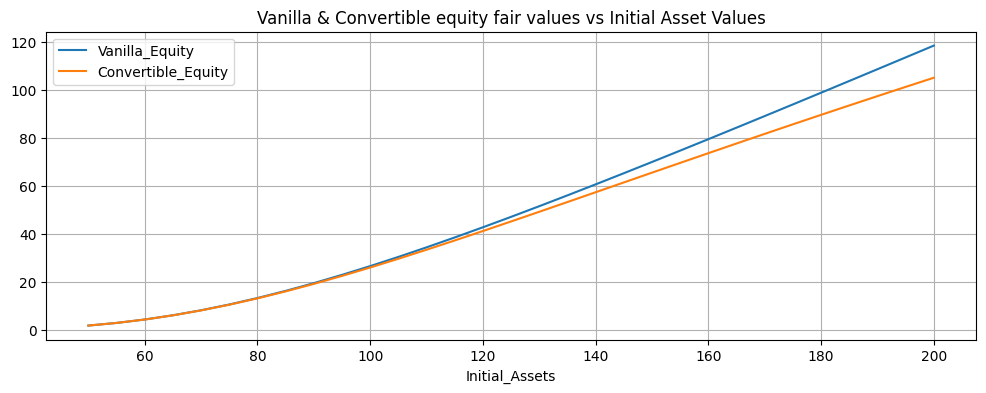

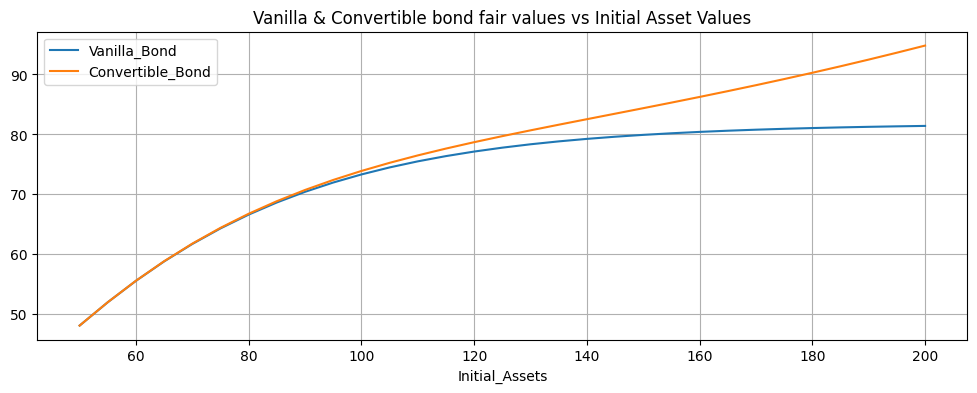

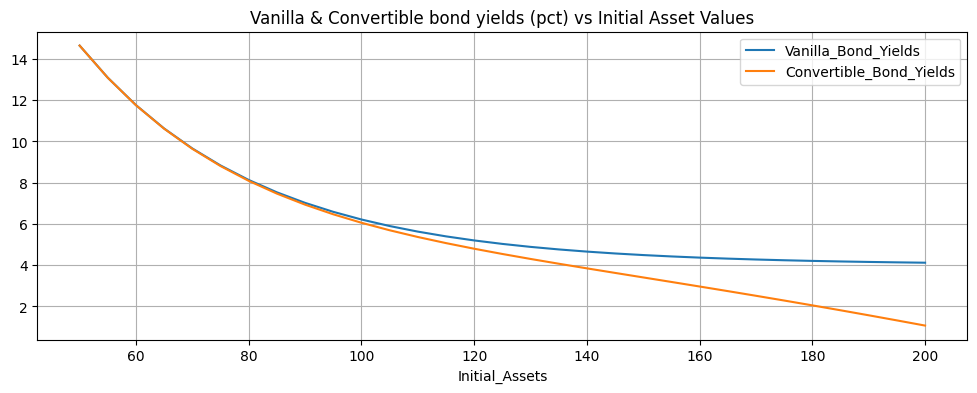

In [11]:
asset_values = [x for x in range(50,205,5)]

vanilla_equity_values = [fairValueEquity(a,r,sigma_A,T,K) for a in asset_values]
convertible_equity_values = [fairValueConvertibleEquity(a,r,sigma_A,T,K,C) for a in asset_values]

vanilla_bond_values = [fairValueRiskyBond(a,r,sigma_A,T,K) for a in asset_values]
convertible_bond_values = [fairValueConvertibleBond(a,r,sigma_A,T,K,C) for a in asset_values]

vanilla_bond_yields = [- np.log(x/K) / T * 100 for x in vanilla_bond_values]
convertible_bond_yields = [- np.log(x/K) / T * 100 for x in convertible_bond_values]



plot_metrics_df = pd.DataFrame(data={'Initial_Assets': asset_values, 
                             'Vanilla_Equity': vanilla_equity_values,
                             'Convertible_Equity': convertible_equity_values,
                             'Vanilla_Bond': vanilla_bond_values,
                             'Convertible_Bond': convertible_bond_values,
                            'Vanilla_Bond_Yields': vanilla_bond_yields,
                             'Convertible_Bond_Yields': convertible_bond_yields})  

# Plot Asset fair values
plot_metrics_df.plot(x='Initial_Assets', y=['Vanilla_Equity', 'Convertible_Equity'], grid=True, title="Vanilla & Convertible equity fair values vs Initial Asset Values", figsize=(12,4))

# Plot Bond fair values
plot_metrics_df.plot(x='Initial_Assets', y=['Vanilla_Bond', 'Convertible_Bond'], grid=True, title="Vanilla & Convertible bond fair values vs Initial Asset Values", figsize=(12,4))

# Plot bond yields
plot_metrics_df.plot(x='Initial_Assets', y=['Vanilla_Bond_Yields', 'Convertible_Bond_Yields'], grid=True, title="Vanilla & Convertible bond yields (pct) vs Initial Asset Values", figsize=(12,4))


-----------------------------------------------------------
# Problem 3: Correlated defaults: homogeneous issuers case
## Follow Lecture 7, "Correlated Defaults"
We are analyzing a pool consisting of n = 100 equally weighted credit issuers with $100 total face notional. Our investment time horizon is T = 5 years.

The pool is homogenous, and each issuer has:
1. a flat hazard rate h = 12%,
2. a constant recovery rate given default of R of 40% and
3. a correlation $\rho$ to the systematic (market) factor.

## a. Expected pool loss to time T

Compute the expected loss in the pool until time T.

In [12]:
# Setting the parameters for the homogeneous pool case
n = 100
h = 0.15
R = 0.40
p = np.exp(-T*h)

# Expected pool loss
expected_pool_loss = n * (1 - p) * (1 - R)

print('expected_pool_loss =', round(expected_pool_loss, 6))

expected_pool_loss = 31.658007


## b. Counting the number of issuer defaults until time T

Write a function that computes the probability of exactly k defaults until time T. 

Use Lecture 7 Section "Correlated defaults" as a reference. 
For the numerical integration, you can use and quad from scipy.integrate (or similar).

$\mathbb{P}\left[L_{T}=k\cdot\frac{\left(1-R\right)}{n}\right]=\mathbb{P}\left[\sum_{i=1}^{n}\mathbb{I}_{\{\tau_{i}\leq T\}}=k\right]=\mathbb{\int_{-\infty}^{\infty}}{n \choose k}\cdot\left(1-p_{x}\right)^{k}\cdot p_{x}^{n-k}\cdot\varphi\left(x\right)dx$

$p_{x}^{i}=\mathbb{P}\left[Z^{i}<\frac{d_{-}^{i}-\rho_{i}\cdot x}{\sqrt{1-\rho_{i}^{2}}}\right]=\Phi\left(\frac{d_{-}^{i}-\rho_{i}\cdot x}{\sqrt{1-\rho_{i}^{2}}}\right)$

$p^{i}=\Phi\left(d_{-}^{i}\right), \forall i = 1..n$

In [13]:
from scipy.stats import binom 

# Calc d_minus
d_minus = norm.ppf(p)    # p = GaussianCDF(d_minus)

# defining the grid of k values: number k of defaulted issuers up to time T
k_defaults_grid = range(n + 1)

# calcCondProbKDefaults
def calcCondProbKDefaults(k, rho, x):
    d_adjusted = (d_minus - rho * x) / np.sqrt(1 - rho*rho)
    p_x = norm.cdf(d_adjusted)
    k_defaults_cond_prob = binom.pmf(k, n, 1 - p_x)
    return k_defaults_cond_prob

# calcProbKDefaults
def calcProbKDefaults(k, rho):

    # Numerical integration
    integrand = lambda x : calcCondProbKDefaults(k, rho, x) * norm.pdf(x)

    # Integrate over market factor x from from -infinity to infinity
    k_defaults_prob, _ = quad(integrand, -np.inf, np.inf)    
    return k_defaults_prob

# calcDefaultsDistribution
def calcDefaultsDistribution(rho):
    return [calcProbKDefaults(k, rho) for k in k_defaults_grid]


## c. Compute the distribution of number of defaults

Generate and plot the distribution and cumulative distribution of number of defaults.

Use a $\rho$ grid: [rho from 0% to 90% in steps of 10%] for plotting (10 lines total).

Comment on the results.

In [14]:
# Generate and plot the distribution and cumulative distribution of number of defaults

# rho_grid
rho_grid = np.linspace(0, 0.9, 10)

# initial dataframe
default_dist_df = pd.DataFrame({'NumOfDefaults': k_defaults_grid})

for rho in rho_grid:
    
    # Add new default_dist column for each rho
    default_dist_df[f'Prob_Rho={round(rho,1)}'] = calcDefaultsDistribution(rho)


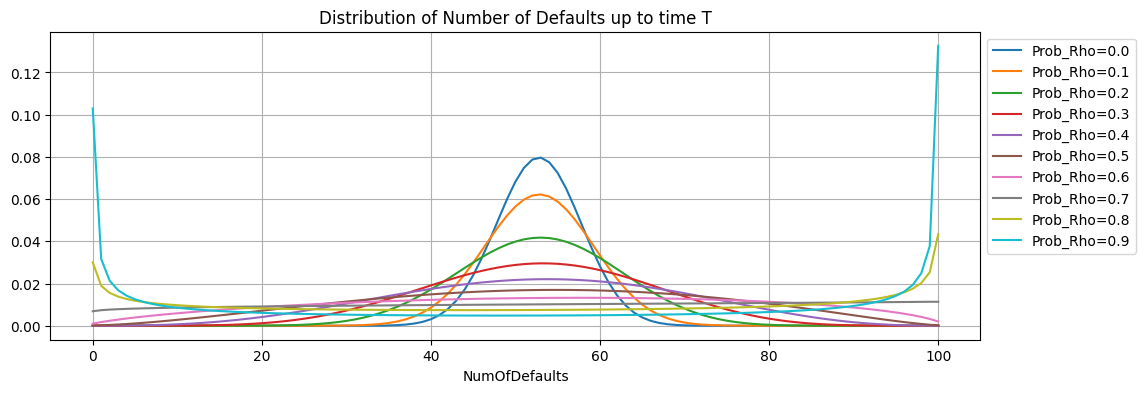

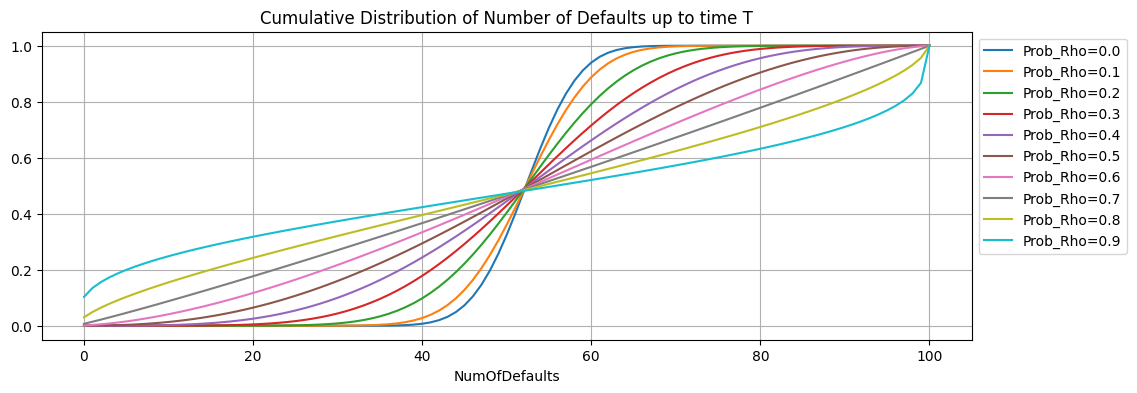

In [15]:
# Plot default distributions
default_dist_df.plot(x='NumOfDefaults', title='Distribution of Number of Defaults up to time T', grid=True, figsize=(12,4)).legend(bbox_to_anchor=(1.0, 1.0))

# Generate cumulative default distributions
cum_default_dist_df = default_dist_df.cumsum()
cum_default_dist_df['NumOfDefaults'] = default_dist_df['NumOfDefaults']

# Plot cumulative default distributions
cum_default_dist_df.plot(x='NumOfDefaults', title='Cumulative Distribution of Number of Defaults up to time T', grid=True, figsize=(12,4)).legend(bbox_to_anchor=(1.0, 1.0))


Comments: the higher the correlation of issuers, the higher the probability of pool losses concentrating in the left or right tail of the distribution (i.e. higher dispersion / standard deviation of the distribution).

## d. Compute the Mean and Standard Deviation of Pool Losses, for all correlation coefficients $\rho$ in the grid

Calculate, display and plot the Mean and Standard Deviation of pool losses for each $\rho$ in the grid.

Comment on the results.

,Rho,Mean_Pool_Loss,StDev_Pool_Loss
0,0.0,31.658007,2.995415
1,0.1,31.658007,3.823327
2,0.2,31.658007,5.617918
3,0.3,31.658007,7.736766
4,0.4,31.658007,9.985762
5,0.5,31.658007,12.316119
6,0.6,31.658007,14.731269
7,0.7,31.658007,17.271809
8,0.8,31.658007,20.036604
9,0.9,31.658007,23.295553


expected_pool_loss = 31.658007
max_numerical_error = 3.454452723872237e-08


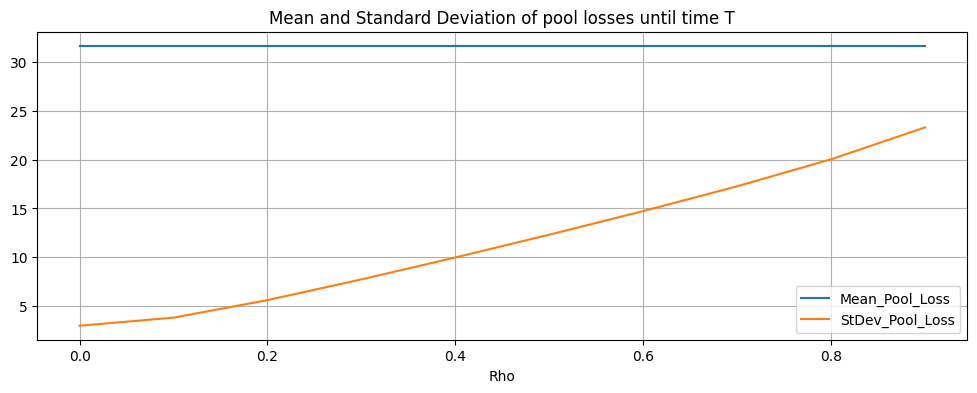

In [16]:
# mean_pool_losses
mean_pool_losses = []
stdev_pool_losses = []
for rho in rho_grid:

    # Calc mean
    mean_num_of_defaults = (default_dist_df['NumOfDefaults'] * default_dist_df[f'Prob_Rho={round(rho,1)}']).sum()
    mean_pool_loss = mean_num_of_defaults * (1 - R)
    mean_pool_losses.append(mean_pool_loss)

    # Calc standard deviation
    var_num_of_defaults = (default_dist_df['NumOfDefaults']**2 * default_dist_df[f'Prob_Rho={round(rho,1)}']).sum()
    var_num_of_defaults = var_num_of_defaults - mean_num_of_defaults**2        
    stdev_pool_loss = np.sqrt(var_num_of_defaults) * (1 - R)    
    stdev_pool_losses.append(stdev_pool_loss)

# pool_losses_df
pool_losses_df = pd.DataFrame({
                        'Rho': rho_grid, 
                        'Mean_Pool_Loss': mean_pool_losses,
                        'StDev_Pool_Loss': stdev_pool_losses})

# Display and plot the results
display(pool_losses_df)
pool_losses_df.plot(x='Rho', title='Mean and Standard Deviation of pool losses until time T', grid=True, figsize=(12,4))

print('expected_pool_loss =', round(expected_pool_loss, 6))
print('max_numerical_error =', (pool_losses_df['Mean_Pool_Loss'] - expected_pool_loss).abs().max())

Comments: 
- The manual calculation shows that mean pool loss for each $\rho$ is constant and equal to the expected pool loss computed in a. (since the expected pool loss is independent from $\rho$).

- This is also an indication that our computations have high numerical accuracy (in the order of 1e-7).

- The standard deviation of the pool loss is increasing in $\rho$: the higher the correlation of issuers, the higher the dispersion of the pool losses.

------------------------------------------------------------------
# Problem 4: Derivation of fixed rate bond PVs and DV01s in `sympy`

Starting from the fair value formula for risky fixed rate bonds in the `flat yield model`, you will derive the formulas for
* Zero coupon bonds (principal payment only, no coupons) and
* "Interest Only" / IO bonds (coupon payments only, no principal payment)

Assume T+0 settlement and zero accrued.

### Flat Yield Model Parameters
* bond face value of 100%
* bond maturity T (in years),
* semi-annual coupon c,
* flat yield y

According to formula [5] in Lecture 1, the bond present value is given by:

\begin{align}
BondPV=B(0,T,c,y)
\end{align}

\begin{align}
=\sum_{k=1}^{2T}\frac{c}{2}\cdot e^{-k\cdot\frac{y}{2}}+e^{-T\cdot y}
\end{align}

\begin{align}
= 1+\frac{\frac{c}{2}-\left( e^{\frac{y}{2}}-1 \right)}{e^{\frac{y}{2}}-1 } \cdot \left(1-e^{-T\cdot y}\right)
\end{align}


The example code below explains how to implement the present value function for the generic fixed rate bond.

It uses the 'sympy' library (symbolic mathematics) to translate mathematical formulas into a sympy symbolic equation, as described in the solution to Homework 3, Problem 2.

The sympy symbolic equation is converted into a Python function via sympy.lambdify.

The function `plot_bond_function_surface(bond_func, 'Plot Title')` plots the Python bond function on a "yield x maturity" 2D discretization grid:

* in yield space: [y from 0% to 10% in steps of 0.5%] and 
* in time-to-maturity space: [T from 1Y to 20Y in steps of 1Y].

We assume a bond coupon c of 5% for plotting purposes.

Analytic formula for bond_pv: (1 - exp(-T*y))*(c/2 - exp(y/2) + 1)/(exp(y/2) - 1) + 1


(1 - exp(-T*y))*(c/2 - exp(y/2) + 1)/(exp(y/2) - 1) + 1

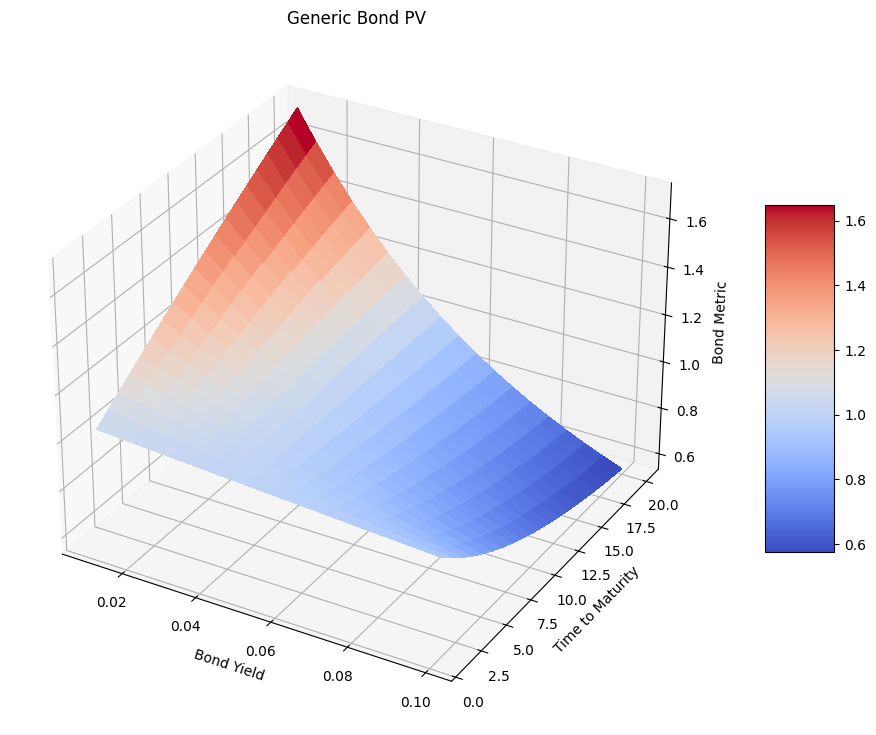

In [17]:
# define symbolic variables
t = sp.symbols('T')
c = sp.symbols('c')
y = sp.symbols('y')

# define symbolic equation for bond pv
bond_pv_eq =  1 + (c/2 -(sp.exp(y/2) - 1)) / (sp.exp(y/2) - 1) * (1 - sp.exp(-t*y))
print('Analytic formula for bond_pv:', bond_pv_eq)
display(bond_pv_eq)

# create function(y,T,y) from equation
bond_pv_func = sp.lambdify([c,t,y], bond_pv_eq)

# Plot the surface
plot_bond_function_surface(bond_pv_func, 'Generic Bond PV')


## a. Derive and plot the DV01 of a Fixed rate bond

Use the sympy "diff()" function to compute & display the derivative of the fixed rate bond PV with respect to the bond yield.

Plot the bond DV01 surface on the "yield x maturity" 2D discretization grid.


Analytic formula for bond_dv01_eq: -T*(c/2 - exp(y/2) + 1)*exp(-T*y)/(exp(y/2) - 1) + (1 - exp(-T*y))*exp(y/2)/(2*(exp(y/2) - 1)) + (1 - exp(-T*y))*(c/2 - exp(y/2) + 1)*exp(y/2)/(2*(exp(y/2) - 1)**2)


-T*(c/2 - exp(y/2) + 1)*exp(-T*y)/(exp(y/2) - 1) + (1 - exp(-T*y))*exp(y/2)/(2*(exp(y/2) - 1)) + (1 - exp(-T*y))*(c/2 - exp(y/2) + 1)*exp(y/2)/(2*(exp(y/2) - 1)**2)

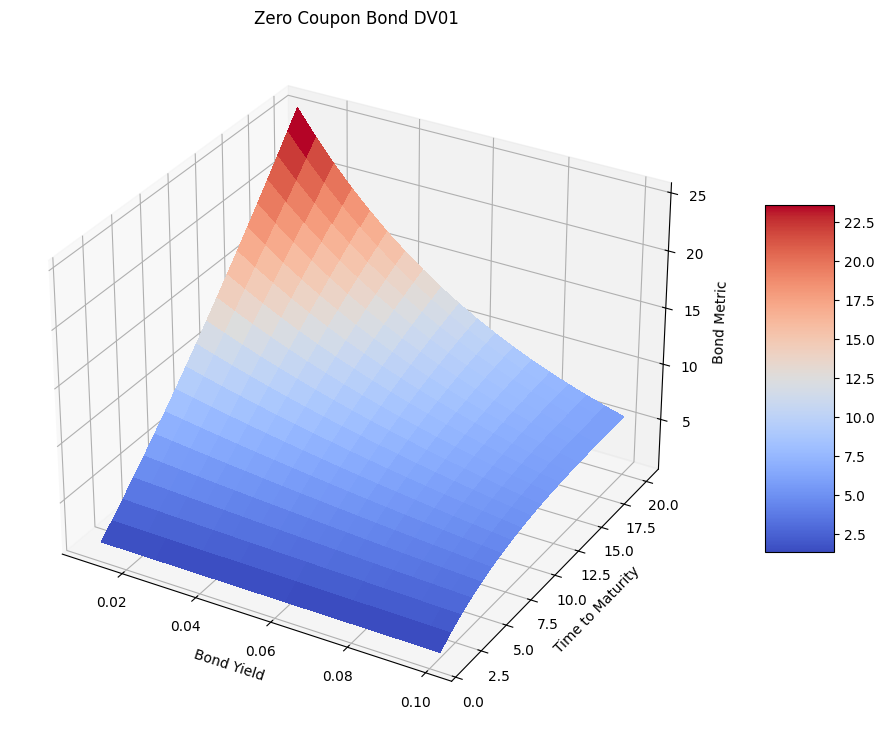

In [18]:
# DV01 = - derivative of Bond PV with respect to yield y
bond_dv01_eq =  - bond_pv_eq.diff(y)
# bond_dv01_eq = sp.simplify(bond_dv01_eq)

print('Analytic formula for bond_dv01_eq:', bond_dv01_eq)
display(bond_dv01_eq)

# create function from equation
bond_dv01_func = sp.lambdify([c, t,y], bond_dv01_eq)

# Plot the surface
plot_bond_function_surface(bond_dv01_func, 'Zero Coupon Bond DV01')


## b. Derive and plot the present value functions for a Zero Coupon bond.

Derive and display the analytic formula for a Zero Coupon bond PV.

Plot the Zero Coupon bond PV surface on the "yield x maturity" 2D discretization grid.

Analytic formula for zero_coupon_bond_pv: exp(-T*y)


exp(-T*y)

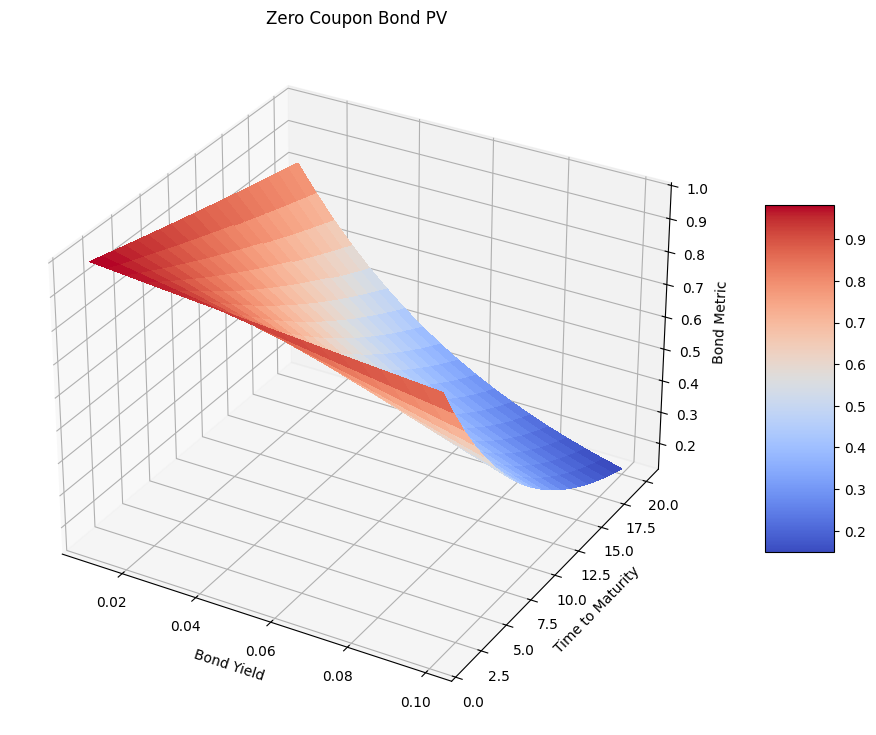

In [19]:
# Define symbolic equation for Zero Coupon bond pv
zero_coupon_bond_pv_eq =  sp.exp(-t*y)
print('Analytic formula for zero_coupon_bond_pv:', zero_coupon_bond_pv_eq)
display(zero_coupon_bond_pv_eq)

# create function from equation
zero_coupon_bond_pv_func = sp.lambdify([c, t,y], zero_coupon_bond_pv_eq)

# Plot the surface
plot_bond_function_surface(zero_coupon_bond_pv_func, 'Zero Coupon Bond PV')


## c. Derive and plot the DV01 of a Zero Coupon bond.

Use the sympy "diff()" function to compute & display the derivative of the Zero Coupon bond PV with respect to the bond yield.

Plot the Zero Coupon bond DV01 surface on the "yield x maturity" 2D discretization grid.


Analytic formula for zero_coupon_bond_dv01: T*exp(-T*y)


T*exp(-T*y)

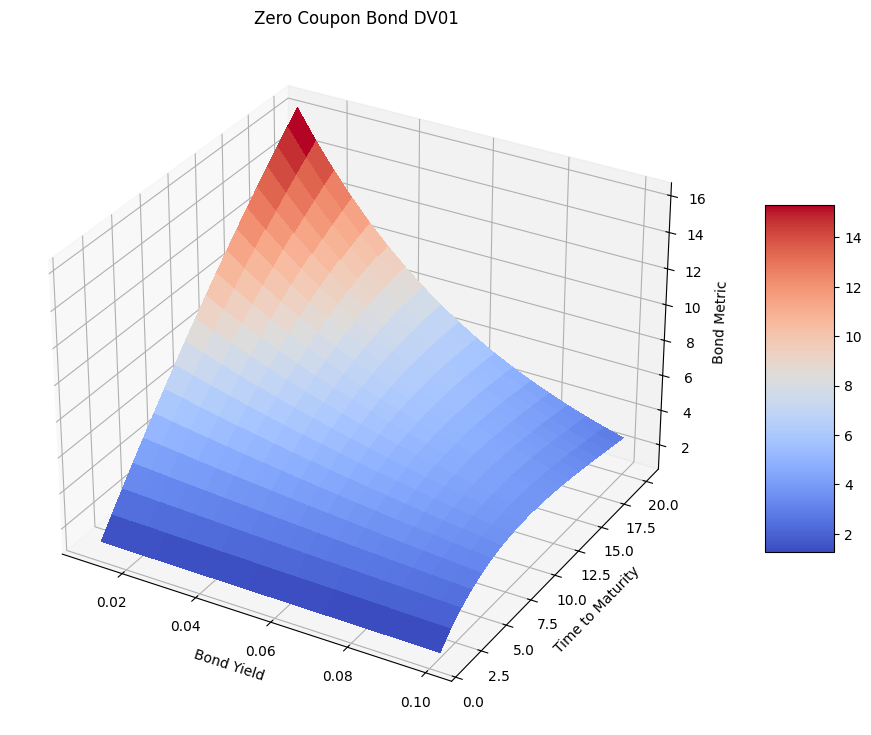

In [20]:
# DV01 = - derivative of Bond PV with respect to yield y
zero_coupon_bond_dv01_eq =  - zero_coupon_bond_pv_eq.diff(y)
print('Analytic formula for zero_coupon_bond_dv01:', zero_coupon_bond_dv01_eq)
display(zero_coupon_bond_dv01_eq)

# create function from equation
zero_coupon_bond_dv01_func = sp.lambdify([c, t,y], zero_coupon_bond_dv01_eq)

# Plot the surface
plot_bond_function_surface(zero_coupon_bond_dv01_func, 'Zero Coupon Bond DV01')


## d. Derive and plot the present value function for an Interest Only bond.

Derive and display the analytic formula for an Interest Only bond PV.

Plot the Interest Only bond PV surface on the "yield x maturity" 2D discretization grid.

Keep in mind that any generic fixed rate bond can be decomposed into Zero Coupon and Interest Only components.

Analytic formula for interest_only_bond_pv: c*(1 - exp(T*y))*exp(-T*y)/(2*(1 - exp(y/2)))


c*(1 - exp(T*y))*exp(-T*y)/(2*(1 - exp(y/2)))

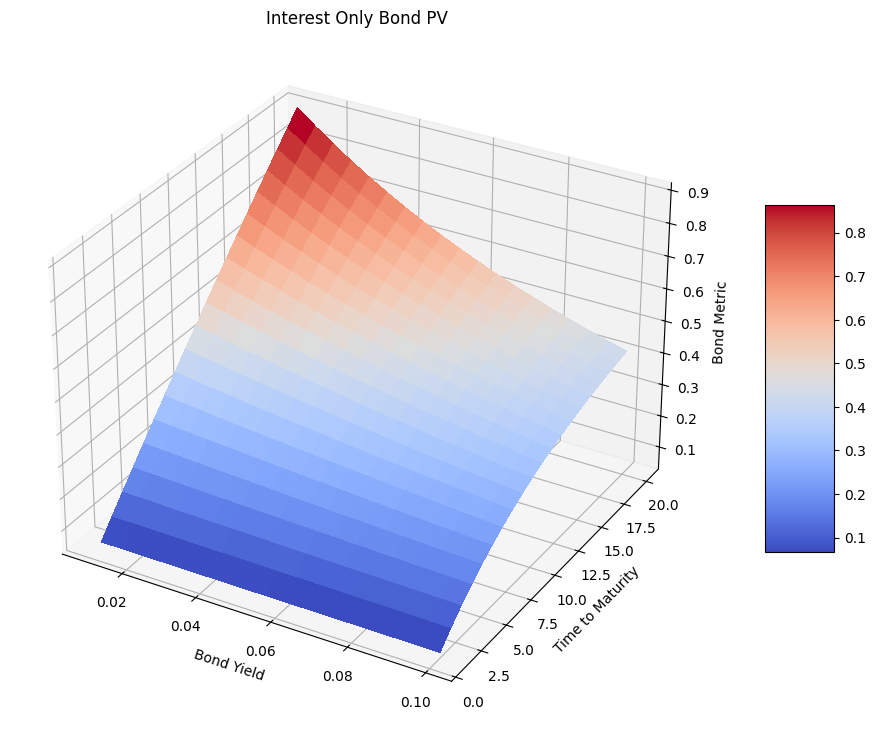

In [21]:
# Define symbolic equation for the Interest Only bond PV
interest_only_bond_pv_eq =  sp.simplify(bond_pv_eq - zero_coupon_bond_pv_eq)
print('Analytic formula for interest_only_bond_pv:', interest_only_bond_pv_eq)
display(interest_only_bond_pv_eq)


# create function from equation
interest_only_bond_pv_func = sp.lambdify([c, t,y], interest_only_bond_pv_eq)

# Plot the surface
plot_bond_function_surface(interest_only_bond_pv_func, 'Interest Only Bond PV')


## e. Derive and plot the DV01 of an Interest Only bond.

Use the sympy "diff()" function to compute and display the derivative of the Interest Only bond PV.

Plot the Interest Only bond DV01 surface on the "yield x maturity" 2D discretization grid.


Analytic formula for interest_only_bond_dv01: T*c*(1 - exp(T*y))*exp(-T*y)/(2*(1 - exp(y/2))) + T*c/(2*(1 - exp(y/2))) - c*(1 - exp(T*y))*exp(y/2)*exp(-T*y)/(4*(1 - exp(y/2))**2)


T*c*(1 - exp(T*y))*exp(-T*y)/(2*(1 - exp(y/2))) + T*c/(2*(1 - exp(y/2))) - c*(1 - exp(T*y))*exp(y/2)*exp(-T*y)/(4*(1 - exp(y/2))**2)

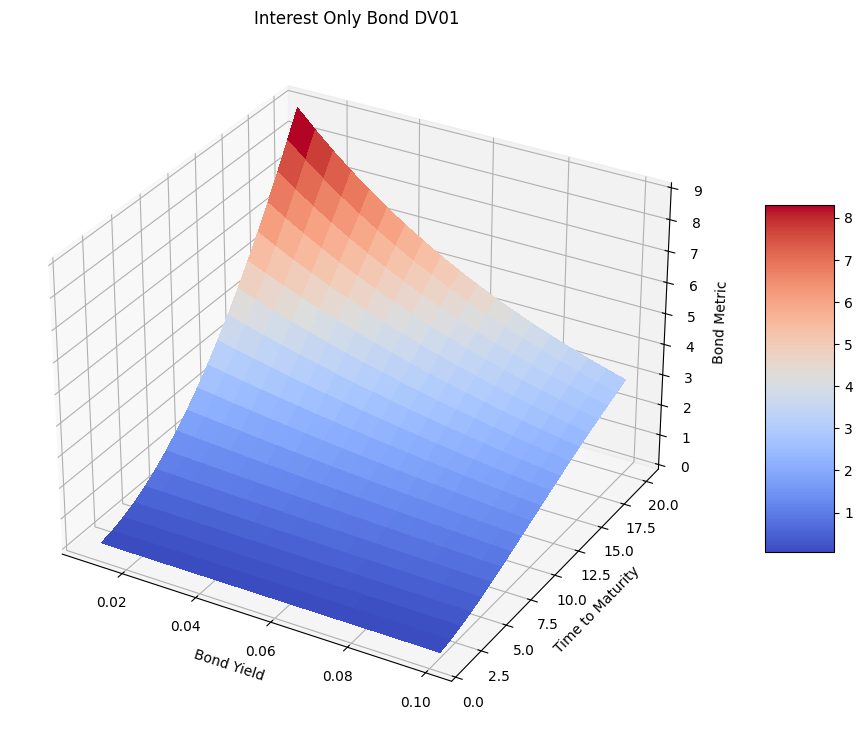

In [22]:
# DV01 = - derivative of Bond PV with respect to yield y
interest_only_bond_dv01_eq =  - interest_only_bond_pv_eq.diff(y)
# interest_only_bond_dv01_eq = sp.simplify(interest_only_bond_dv01_eq)

print('Analytic formula for interest_only_bond_dv01:', interest_only_bond_dv01_eq)
display(interest_only_bond_dv01_eq)

# create function from equation
interest_only_bond_dv01_func = sp.lambdify([c, t,y], interest_only_bond_dv01_eq)

# Plot the surface
plot_bond_function_surface(interest_only_bond_dv01_func, 'Interest Only Bond DV01')


## f. For which bond coupon $c^*$ are the Interest Only PV and the Zero Coupon PV equal?
 
### Find the bond coupon $c^*$ satisfying:

\begin{align}
InterestOnlyPV(c^*, y,T) = ZeroCouponPV(y,T)
\end{align}

Display the formula for $c^*$.

In [23]:
# c_star_eq_v1: first method
c_star_eq_v1 =  zero_coupon_bond_pv_eq / (interest_only_bond_pv_eq / c)
print('Formula for c_star_eq_v1:', c_star_eq_v1)
display(c_star_eq_v1)

# c_star_eq_v2: second method
c_star_eq_v2 = sp.solve(interest_only_bond_pv_eq - zero_coupon_bond_pv_eq, c)[0]
print('Formula for c_star_eq_v2:', c_star_eq_v2)
display(c_star_eq_v2)

Formula for c_star_eq_v1: 2*(1 - exp(y/2))/(1 - exp(T*y))


2*(1 - exp(y/2))/(1 - exp(T*y))

Formula for c_star_eq_v2: 2*(1 - exp(y/2))/(1 - exp(T*y))


2*(1 - exp(y/2))/(1 - exp(T*y))